# The Simpsons classification

## Requirements

In [85]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split,SubsetRandomSampler
import torchvision
from torchvision.datasets import ImageFolder
#import torchinfo
from torchmetrics import F1Score
import matplotlib.pyplot as plt
%matplotlib inline

## Hyperparameters and constants

In [86]:
lr = 0.005
batch_size = 32
epochs = 20

class_number = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_names = ['abraham_grampa_simpson',
            'agnes_skinner',
            'apu_nahasapeemapetilon',
            'barney_gumble',
            'bart_simpson',
            'carl_carlson',
            'charles_montgomery_burns',
            'chief_wiggum',
            'cletus_spuckler',
            'comic_book_guy',
            'disco_stu',
            'edna_krabappel',
            'fat_tony',
            'gil',
            'groundskeeper_willie',
            'homer_simpson',
            'kent_brockman',
            'krusty_the_clown',
            'lenny_leonard',
            'lionel_hutz',
            'lisa_simpson',
            'maggie_simpson',
            'marge_simpson',
            'martin_prince',
            'mayor_quimby',
            'milhouse_van_houten',
            'miss_hoover',
            'moe_szyslak',
            'ned_flanders',
            'nelson_muntz',
            'otto_mann',
            'patty_bouvier',
            'principal_skinner',
            'professor_john_frink',
            'rainier_wolfcastle',
            'ralph_wiggum',
            'selma_bouvier',
            'sideshow_bob',
            'sideshow_mel',
            'snake_jailbird',
            'troy_mcclure',
            'waylon_smithers']

## NN model

In [87]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 42)

        
        self.train_losses = []
        self.valid_losses = []
        self.test_accs = []

    def forward(self, input):
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.pool(output)
        output = output.view(-1, 512)
        output = self.fc1(output)
        return output

    def saveModel(self, filename='./simpsons_model.pth'):
        torch.save(obj=self.state_dict(), f=filename)

    def trainStep(self,epoch,optimizer,train_loader,criterion):
        running_loss = 0.0
        for step, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if step % 100 == 99:
                print(f'[{epoch + 1}, {step + 1:5d}] loss: {loss.item():.3f}')
                    
        return running_loss

    
    def validStep(self,valid_loader,criterion):
        running_loss = 0.0
        #val_avg_f1 = F1Score(task="multiclass", num_classes=42).to(device)
        
        with torch.no_grad():
            for step, data in enumerate(valid_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                #_, predicted = torch.max(outputs.data, 1)
                #val_avg_f1.update(predicted,labels)
                
                #if step % 23 == 22:    # print every 23 mini-batches
                #    print(f'[{epoch + 1}, {step + 1:5d}] loss: {loss.item():.3f}')
        #val_avg_f1.compute()
        return running_loss 
        
        
        
    def train(self, optimizer, train_loader,valid_loader, criterion ,epochs):
        print('Training started')
        train_step_number = len(train_loader)
        val_step_number = len (valid_loader)
        
        for epoch in range(epochs):
            self.train_losses.append(self.trainStep(epoch,optimizer, train_loader, criterion)/train_step_number)
            val_loss = self.validStep(valid_loader,criterion)/val_step_number
            self.valid_losses.append(val_loss)
        
        print('Training finished')

    def test(self, test_loader):
        print('Testing started')
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

        avg_f1 = F1Score(task="multiclass", num_classes=42).to(device)
        class_f1 =F1Score(task="multiclass", num_classes=42,average=None).to(device)
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = self(images)

                _, predicted = torch.max(outputs.data, 1)
                   
                avg_f1.update(outputs,labels)
                class_f1.update(predicted,labels)
                
        self.test_accs = class_f1.compute() 
        
        print('Testing finished')     
        print(f"F1(torchmetrics): {avg_f1.compute():.3%}")
        

## Optimizer and Loss function

In [88]:
model = Network()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Data spliting

In [89]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
                                                torchvision.transforms.Resize((32,32))])
dataset = ImageFolder(
    "../input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset", transform=transform)

targets = dataset.targets

from sklearn.model_selection import train_test_split
train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets
)

valid_idx, test_idx  = train_test_split(
    np.arange(len(targets)),
    test_size=0.8,
    shuffle=True,
    stratify=targets
)

train_sampler =SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size, num_workers=1,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, num_workers=1,sampler = test_sampler)
valid_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, num_workers=1,sampler = valid_sampler)

## Training

In [90]:
model.train(optimizer,train_loader,valid_loader,criterion,epochs)

Training started
[1,   100] loss: 2.790
[1,   200] loss: 2.151
[1,   300] loss: 1.695
[1,   400] loss: 1.536
[2,   100] loss: 1.374
[2,   200] loss: 1.416
[2,   300] loss: 0.807
[2,   400] loss: 0.852
[3,   100] loss: 0.740
[3,   200] loss: 0.673
[3,   300] loss: 0.782
[3,   400] loss: 0.972
[4,   100] loss: 0.805
[4,   200] loss: 0.677
[4,   300] loss: 0.671
[4,   400] loss: 0.783
[5,   100] loss: 0.469
[5,   200] loss: 0.582
[5,   300] loss: 0.327
[5,   400] loss: 0.787
[6,   100] loss: 0.533
[6,   200] loss: 1.049
[6,   300] loss: 0.549
[6,   400] loss: 0.499
[7,   100] loss: 0.998
[7,   200] loss: 0.547
[7,   300] loss: 0.540
[7,   400] loss: 0.320
[8,   100] loss: 0.428
[8,   200] loss: 0.523
[8,   300] loss: 0.579
[8,   400] loss: 0.377
[9,   100] loss: 0.403
[9,   200] loss: 0.204
[9,   300] loss: 0.479
[9,   400] loss: 0.555
[10,   100] loss: 0.194
[10,   200] loss: 0.474
[10,   300] loss: 0.448
[10,   400] loss: 0.678
[11,   100] loss: 0.328
[11,   200] loss: 0.319
[11,   300]

Text(0, 0.5, 'Loss')

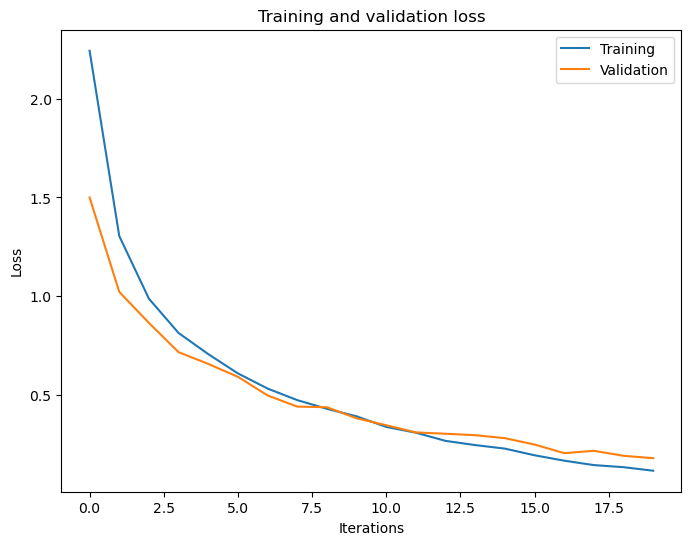

In [91]:
fig = plt.figure(figsize=(8, 6))
plt.plot(model.train_losses,label = 'Training')
plt.plot(model.valid_losses,label = 'Validation')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Testing

In [92]:
model.saveModel()
#model.test(test_loader)

In [93]:
net = Network().to(device)
net.load_state_dict(torch.load("/kaggle/working/simpsons_model.pth"))

<All keys matched successfully>

In [94]:
net.test(test_loader)

Testing started
Testing finished
F1(torchmetrics): 95.050%


<BarContainer object of 42 artists>

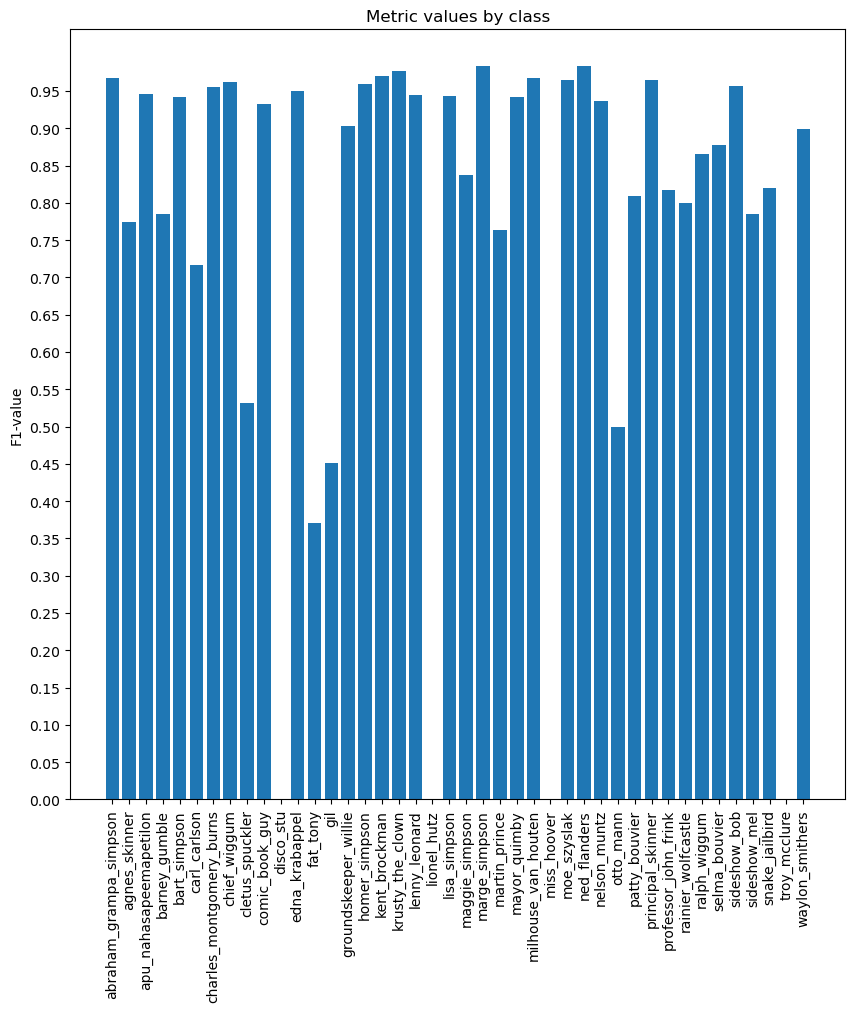

In [95]:
bar = plt.figure(figsize=(10,10))
plt.title("Metric values by class")
plt.ylabel('F1-value')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0, 1.00, 0.05))
plt.bar(class_names, np.array(net.test_accs.cpu()))